In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import signal, stats, fftpack
import mplcursors
from glob import glob
import time

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_stim_events, find_nearest_ind
from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [5]:
%matplotlib notebook

#### Plot electrodes

### Load experiment

In [6]:
recfolder = r'P:\mouse709402\signal_test_2024-02-05_13-18-30\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: sensory stimulation


### Load EEG data and stimulus log

In [7]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])

In [8]:
bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [9]:
stim_log = pd.read_csv(exp.stimulus_log_file)
if 'good' not in stim_log.columns:
    qualitycheck_trials(exp, known_bad_chs=bad_chs)
    stim_log = pd.read_csv(exp.stimulus_log_file)

In [10]:
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good
0,circle,white,183.34588,183.57826,0.23238,0,True
1,circle,white,187.64200,187.88222,0.24022,0,True
2,circle,white,191.95670,192.20240,0.24570,0,True
3,circle,white,195.98513,196.22247,0.23734,0,True
4,circle,white,199.91969,200.15899,0.23930,0,True


In [11]:
print(np.sum(stim_log['good'].values == True))

226


In [12]:
sweeps = np.unique(stim_log['sweep'].values)

### Load messages

In [13]:
msg_file = sorted(glob(recfolder + '/**/text.npy', recursive=True))[0]
msg = np.load(msg_file).astype(str)

msgSN_file = sorted(glob(os.path.dirname(msg_file) + '/sample_numbers.npy', recursive=True))[0]
msg_samples = np.load(msgSN_file)

eeg_samples = np.load(os.path.join(os.path.dirname(exp.ephys_params['EEG']['timestamps']), 'sample_numbers.npy'))

In [14]:
msg

array([], dtype='<U513')

### Get sweep onsets (for spontaneous time)

In [16]:
sweep_onsets = [eeg_ts[0]]
for i in sweeps[1:]:
    sweep_onsets.append(msg_ts[msg == str(i)][0])
sweep_onsets = np.array(sweep_onsets)
print(sweep_onsets)

[   5.62689963  778.02992636 1601.52971827 2343.00719007 3100.56132588
 3853.50771844]


#### Analyze spectrum for first 120 s of each sweep

In [17]:
sweep_spectra = {}
for sweepi, onseti in zip(sweeps, sweep_onsets):
    start_samp = find_nearest_ind(eeg_ts, onseti)
    end_samp = start_samp + int(120. * exp.ephys_params['EEG']['sample_rate'])
    
    frex, Pxx = signal.welch(
        eeg_data[start_samp:end_samp, :],
        exp.ephys_params['EEG']['sample_rate'],
        nperseg=2 * exp.ephys_params['EEG']['sample_rate'],
        axis=0
    )
    sweep_spectra[sweepi] = [frex, Pxx]

<IPython.core.display.Javascript object>


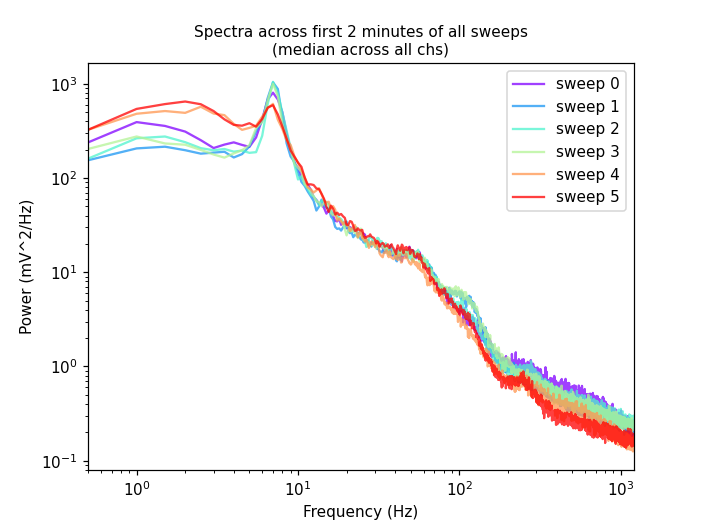

In [52]:
fmax = 1200

fig, ax = plt.subplots()
colors = plt.cm.rainbow(np.linspace(0, 1, len(sweeps)))
for sweepi, spectrai in sweep_spectra.items():
    frinds = spectrai[0] < fmax
    ax.loglog(
        spectrai[0][frinds], np.median(spectrai[1], axis=1)[frinds], color=colors[sweepi],
        linewidth=1.5, alpha=0.75, label='sweep {:d}'.format(sweepi)
    )
ax.set_xlim([0.5, fmax])
ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes of all sweeps\n(median across all chs)')

### SAVE: this will save the figure in the recording1 folder ###
fig_name = 'spectra_allsweeps.png'
# fig.savefig(os.path.join(recfolder, fig_name), transparent=True)

### Plot one sweep, all chs

<IPython.core.display.Javascript object>


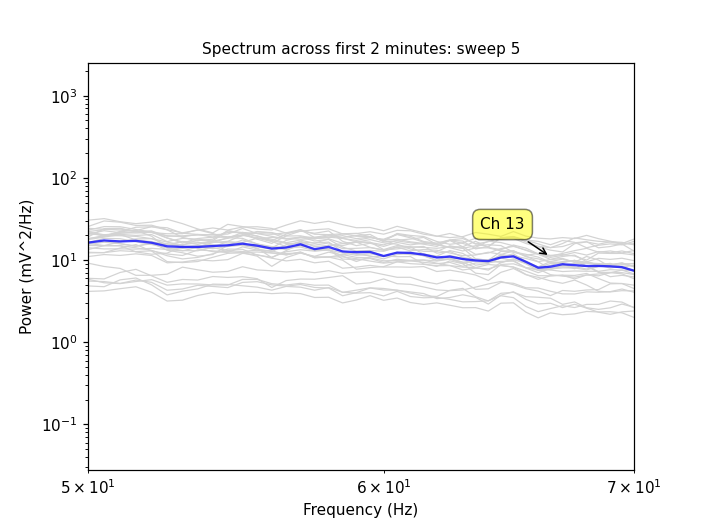

Text(0.5, 1.0, 'Spectrum across first 2 minutes: sweep 5')

In [30]:
plot_sweep = 5
fwin = [50, 70]

fig, ax = plt.subplots()
sweep_spectra[plot_sweep][0]
spectra = ax.loglog(sweep_spectra[plot_sweep][0], sweep_spectra[plot_sweep][1], color='lightgray', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(ind))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(sweep_spectra[plot_sweep][0], np.median(sweep_spectra[plot_sweep][1], axis=1), color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim(fwin)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectrum across first 2 minutes: sweep {:d}'.format(plot_sweep))

### Stim evoked traces

In [37]:
plot_before = 0.5 # s, look at 500 ms pre-stim
plot_after = 1.0 # s, look at 1000 ms post-stim
remove_bad_trials = False

## Loop through all stim events/sweeps and collect traces
avg_traces = {}
for st_type in stim_log.stim_type.unique():
    avg_traces[st_type] = {}
    
    param_list = np.sort(stim_log[stim_log['stim_type']==st_type].parameter.unique())
    for parami in param_list:
        avg_traces[st_type][parami] = {}
        
        sweep_list = np.sort(stim_log[(stim_log['stim_type']==st_type) & (stim_log['parameter']==parami)].sweep.unique())
        for sweepi in sweep_list:
            avg_traces[st_type][parami][sweepi] = {}
            print('{}, {}, sweep {:d}'.format(st_type, str(parami), sweepi))
            ## Get event times ##
            events = get_stim_events(stim_log, st_type, parami, sweepi, remove_bad_epochs=remove_bad_trials)
            if len(events) == 0:
                print('no good trials found')
                continue
            ## Get event traces ##
            event_traces, event_ts = get_evoked_traces(
                eeg_data,
                eeg_ts,
                events,
                plot_before,
                plot_after,
                exp.ephys_params['EEG']['sample_rate']
            )
            comavg_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
            
            ## Design Butterworth bandpass filter ##
            filtb, filta = signal.butter(
                3,
                np.array([0.1, 100])/(exp.ephys_params['EEG']['sample_rate']/2),
                btype='bandpass'
            )
            
            ## Store traces ##
            avg_traces[st_type][parami][sweepi]['raw'] = [event_ts, np.mean(event_traces, axis=2)]
            avg_traces[st_type][parami][sweepi]['filtered'] = [
                event_ts,
                np.mean(signal.filtfilt(filtb, filta, event_traces, axis=0), axis=2)
            ]
            avg_traces[st_type][parami][sweepi]['common_averaged'] = [
                event_ts,
                np.mean(signal.filtfilt(filtb, filta, comavg_traces, axis=0), axis=2)
            ]

circle, white, sweep 0
circle, white, sweep 1
circle, white, sweep 2
circle, white, sweep 3
circle, white, sweep 4
circle, white, sweep 5


### Plotting

Plot all sweeps on one ch: ch 4 is over left VISp where we should observe the largest VEP (ch 25 is right VISp)

<IPython.core.display.Javascript object>


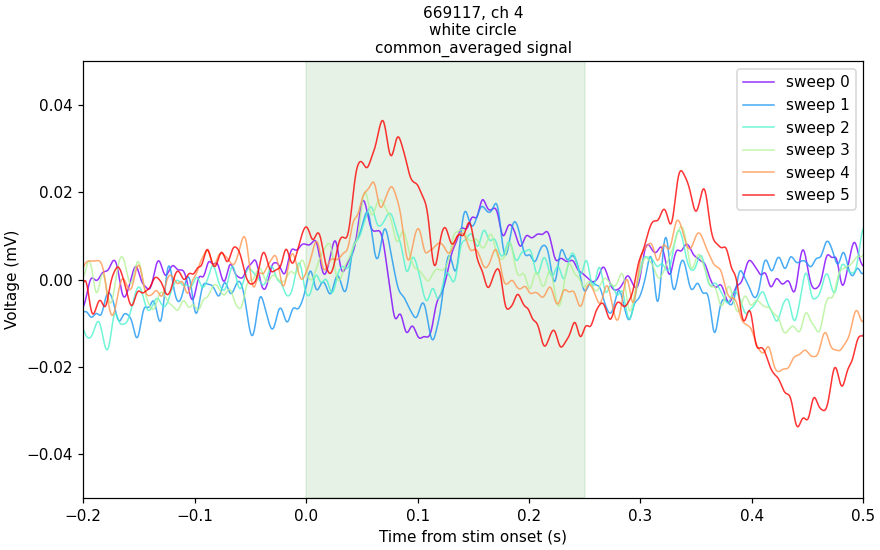

In [61]:
plot_ch = 4
plot_stim_type = 'circle'
plot_stim_param = 'white'
plot_traces = 'common_averaged' # choose: 'raw', 'filtered', or 'common_averaged'
plot_win = [-0.2, 0.5]
ylimit = 0.05 # mV, for visual 0.05

colors = plt.cm.rainbow(np.linspace(0, 1, len(sweeps)))
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.axvspan(0., 0.25, color='g', alpha=0.1)
for sweepi in sweeps:
    timex = avg_traces[plot_stim_type][plot_stim_param][sweepi][plot_traces][0]
    traces = avg_traces[plot_stim_type][plot_stim_param][sweepi][plot_traces][1]
    ax.plot(timex, traces[:, plot_ch]/1000, color=colors[sweepi], linewidth=1.0, alpha=0.8, label='sweep {:d}'.format(sweepi))

ax.legend()
ax.set_xlim(plot_win)
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}, ch {:d}\n{} {}\n{} signal'.format(exp.mouse, plot_ch, str(plot_stim_param), plot_stim_type, plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_ch{:d}_{}{}_arrayplot_allsweeps.png'.format(plot_traces, plot_ch, plot_stim_type, str(plot_stim_param))
fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

## Original plots

Plot the visual evoked response across all electrodes. This plots all electrodes in the array layout, with bad chs in red. You can choose to plot:
- 'raw': raw signals, averaged across all trials
- 'filtered': bandpass filtered signals, averaged across all trials
- 'common_averaged': raw signals that have been common average referenced to all good chs, then filtered and averaged across all trials

<IPython.core.display.Javascript object>


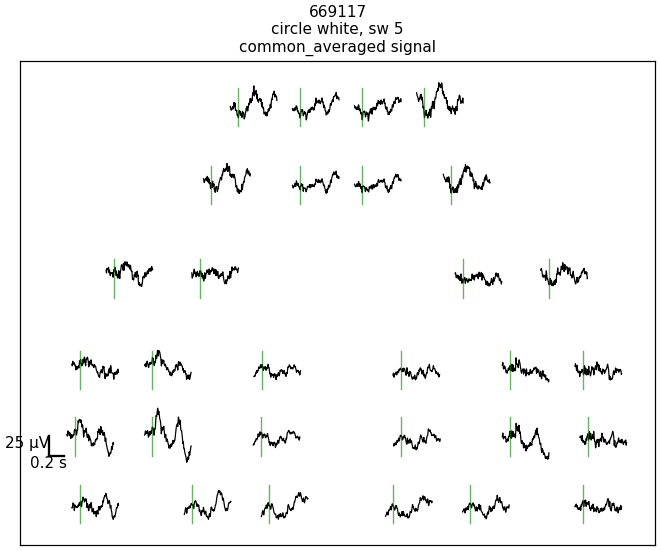

In [59]:
plot_stim_type = 'circle'
plot_stim_param = 'white'
plot_sweep = 5
plot_traces = 'common_averaged' # choose: 'raw', 'filtered', or 'common_averaged'

# if remove_bad_trials:
#     tag = 'good'
# else:
#     tag = 'all'

prex = .1 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8 # changes horizontal distance between traces, usually 0.8
ymult = 80 # changes vertical distance between traces, usually 100 for VEPs

timex = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][0]
plottraces = avg_traces[plot_stim_type][plot_stim_param][plot_sweep][plot_traces][1]
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
        continue
    ax.plot(
        timex[pinds] + (exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        plottraces[pinds, chi] + (exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        trace_color,
        linewidth=0.8
    )
    # this adds a vertical green line at stim onset time #
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
             0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
            [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
             25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
            color='g', linewidth=0.9, alpha=0.6)
#     ax.plot([0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),
#              0.1+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
#             [-25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),
#              25+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
#             color='r', linewidth=0.9, alpha=0.6)
    if chi == 3:
        mx = timex[0] + exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult * 0.95
        my = exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

## This plots a scale bar in the bottom left corner ##
x_len = .2 # x scale bar length in ms
y_len = 25 # y scale bar length in uV, for VEP: 25
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

## Set title ##
ax.set_title('{}\n{} {}, sw {:d}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_sweep, plot_traces))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_arrayplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)

## UNCOMMENT TO SAVE THE FIGURE ##
# fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

In [17]:
snr_dur = 0.2

binds = np.squeeze(np.argwhere((timex >= -snr_dur) & (timex < 0)))
rinds = np.squeeze(np.argwhere((timex > 0) & (timex <= snr_dur)))

base_power = np.mean(np.square(plottraces[binds, :]), axis=0)
resp_power = np.mean(np.square(plottraces[rinds, :]), axis=0)
snrs = np.sqrt(resp_power / base_power)
print(snrs)
print(np.mean(snrs))

[0.70841635 2.7416789  4.85274096 2.27132358 2.84064912 4.33549939
 2.15129627 1.51050208 2.49615092 1.23668644 1.90003553 2.22789073
 2.20750114 1.49678359 1.48251946 1.59217283 1.65039404 2.51583833
 1.79469103 1.5945336  1.79258777 1.19873267 1.90895998 1.53877294
 1.65479374 1.30538972 1.10054598 3.18251007 2.0054659  1.0814797 ]
2.0125514252076973


#### Same plot above, but as a butterfly plot

<IPython.core.display.Javascript object>


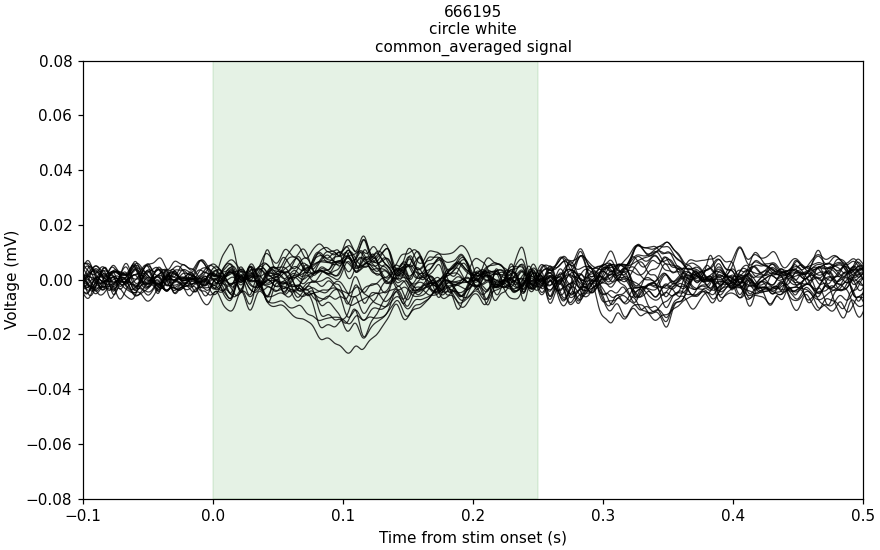

In [18]:
ylimit = 0.08 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
for chi in GOOD_CHS:
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000, color='k', linewidth=0.8, alpha=0.8)
ax.axvspan(0., 0.25, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_butterflyplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)
# fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

#### Same plot, but with electrodes vertically stacked

<IPython.core.display.Javascript object>


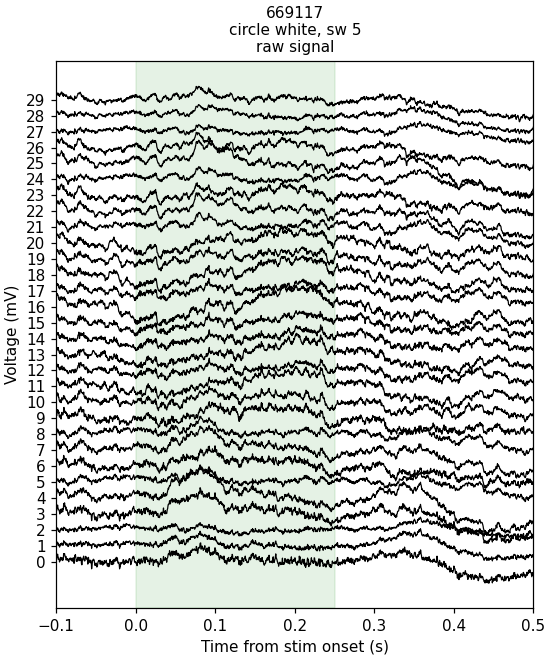

In [58]:
sep = 0.025 # mV, for visual 0.05

fig, ax = plt.subplots(figsize=(5, 6), constrained_layout=True)
for chi in range(len(exp.EEG_channel_coordinates)):
    if chi in GOOD_CHS:
        trace_color = 'k'
    else:
        trace_color = 'r'
        continue
    ax.plot(timex[pinds], plottraces[pinds, chi]/1000 + sep*chi, color=trace_color, linewidth=0.8)
ax.axvspan(0., 0.25, color='g', alpha=0.1)

ax.set_xlim([-prex, postx])
ax.set_xlabel('Time from stim onset (s)')
ax.set_yticks(np.arange(0, sep*(chi+1), sep))
ax.set_yticklabels(range(len(exp.EEG_channel_coordinates)))
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}, sw {:d}\n{} signal'.format(exp.mouse, plot_stim_type, str(plot_stim_param), plot_sweep, plot_traces))

### SAVE: this will save the figure in the recording1 folder ###
fig_name = '{}VEPs_{}{}_stackedplot_sweep{:d}.png'.format(plot_traces, plot_stim_type, str(plot_stim_param), plot_sweep)
# fig.savefig(os.path.join(recfolder, fig_name), transparent=False)

### Plot whole traces

<IPython.core.display.Javascript object>


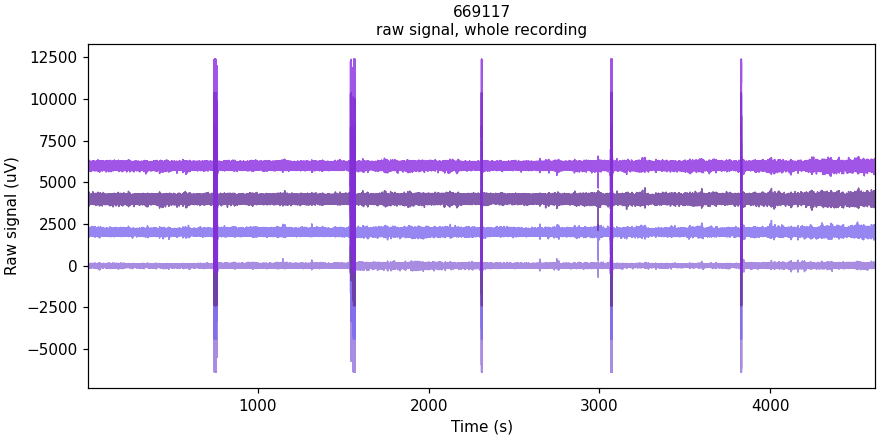

In [60]:
plot_chs = [1,4,10,17]
chcolors = ['mediumpurple','mediumslateblue','rebeccapurple','blueviolet','darkorchid','darkviolet']
# chcolors = ['crimson','blue','gold','green','darkviolet','deeppink']

offset = 2000 # 500
fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)

for i, chi in enumerate(plot_chs):
    ax.plot(eeg_ts, eeg_data[:,chi] + i*offset, color=chcolors[i], linewidth=1, alpha=0.8, label=('Ch {:d}'.format(chi)))

ax.set_xlim((eeg_ts[0], eeg_ts[-1]))
# ax.set_ylim((-500, 2200))

ax.set_xlabel('Time (s)')
ax.set_ylabel('Raw signal (uV)')
ax.set_title('{}\nraw signal, whole recording'.format(exp.mouse))
# ax.legend()

### SAVE: this will save the figure in the recording1 folder ###
fig_name = 'whole_raw_signals.png'
# fig.savefig(os.path.join(recfolder, fig_name), transparent=True)

### Look at spectrum of chs

In [18]:
start_samp = int(300. * exp.ephys_params['EEG']['sample_rate'])
end_samp = start_samp + int(120. * exp.ephys_params['EEG']['sample_rate'])
frex, Pxx = signal.welch(
#     eeg_data[:int(120 * exp.ephys_params['EEG']['sample_rate'])+1, :], # looks at first 120 s
    eeg_data[start_samp:end_samp, :],
    exp.ephys_params['EEG']['sample_rate'],
    nperseg=2 * exp.ephys_params['EEG']['sample_rate'],
    axis=0
)

<IPython.core.display.Javascript object>


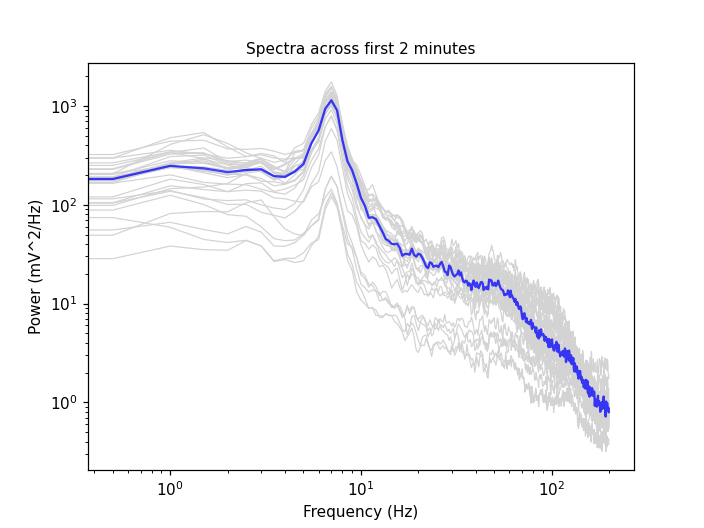

Text(0.5, 1.0, 'Spectra across first 2 minutes')

In [19]:
frinds = frex < 200

fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds,:], color='lightgray', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(ind))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(frex[frinds], np.median(Pxx, axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
# ax.set_xlim([0, 200])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes')

In [20]:
bad_chs = []
print(bad_chs)
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
BAD_CHS = np.array(bad_chs)

[]


<IPython.core.display.Javascript object>


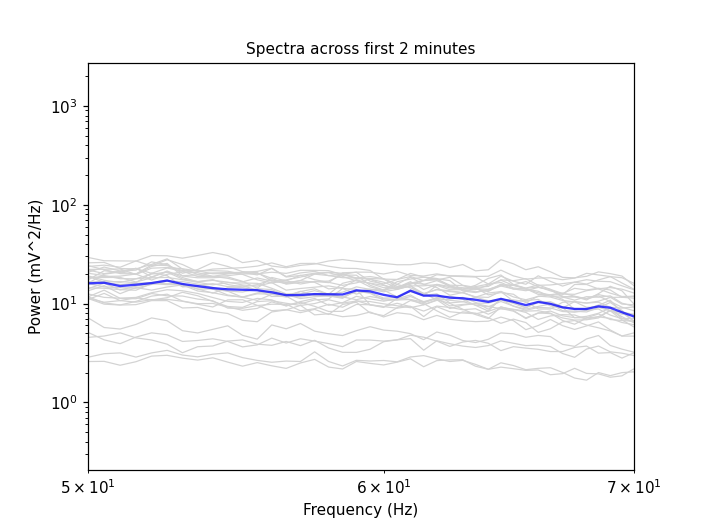

Text(0.5, 1.0, 'Spectra across first 2 minutes')

In [21]:
fig, ax = plt.subplots()

spectra = ax.loglog(frex[frinds], Pxx[frinds,:][:,GOOD_CHS], color='lightgray', linewidth=0.8)
if BAD_CHS.size > 0:
    ax.loglog(frex[frinds], Pxx[frinds,:][:,BAD_CHS], color='r', linewidth=0.8)
for ind, spec in enumerate(spectra):
    spec.set_label('Ch {}'.format(GOOD_CHS[ind]))
cursor = mplcursors.cursor(spectra, hover=True)
cursor.connect('add', lambda sel: sel.annotation.set_text(sel.artist.get_label()))

ax.loglog(frex[frinds], np.median(Pxx[:,GOOD_CHS], axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
ax.set_xlim([50, 70])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Spectra across first 2 minutes')